LangChain과 LangGraph는 둘 다 대규모 언어 모델(LLM)을 활용한 애플리케이션을 구축하기 위한 프레임워크지만, 접근 방식과 주요 기능에 중요한 차이가 있습니다:

## LangChain

1. **목적**: LLM 애플리케이션 개발을 위한 종합적인 프레임워크
2. **구조**: 컴포넌트 기반 접근 방식 (Chains, Agents, Tools, Retrievers 등)
3. **특징**:
   - 다양한 LLM 및 임베딩 모델과의 통합
   - 다양한 데이터 소스와의 연결 (벡터 데이터베이스, 파일 시스템 등)
   - 시퀀셜하고 선형적인 처리 흐름
   - 재사용 가능한 컴포넌트 라이브러리
4. **유연성**: 다양한 사용 사례를 위한 범용 프레임워크

## LangGraph

1. **목적**: 상태 관리와 제어 흐름에 중점을 둔 LLM 애플리케이션 프레임워크
2. **구조**: 상태 머신과 그래프 기반 접근 방식
3. **특징**:
   - LangChain 위에 구축됨 (LangChain의 확장으로 볼 수 있음)
   - 복잡한 흐름 제어와 조건부 분기가 가능
   - 상태 관리에 중점 (불변성 강조)
   - 순환 및 반복적인 작업 흐름을 쉽게 정의
   - 흐름 시각화 및 디버깅 도구
4. **사용 사례**: 대화형 에이전트, 다단계 추론 시스템, 복잡한 의사결정 흐름

## 핵심 차이점

1. **흐름 제어**:
   - LangChain: 주로 선형적인 체인 구조
   - LangGraph: 비선형적, 순환적 그래프 구조 (상태 머신 원리)

2. **상태 관리**:
   - LangChain: 암시적 상태 관리
   - LangGraph: 명시적이고 체계적인 상태 관리

3. **복잡성**:
   - LangChain: 간단한 애플리케이션에 더 적합
   - LangGraph: 복잡한 흐름과 의사결정이 필요한 경우에 더 적합

4. **관계**:
   - LangGraph는 실제로 LangChain의 확장으로, LangChain의 구성 요소들을 활용하면서 그래프 기반의 애플리케이션 구조를 제공합니다.

많은 개발자들이 두 프레임워크를 함께 사용하며, LangChain의 다양한 구성 요소와 도구를 활용하면서 LangGraph로 복잡한 흐름과 상태 관리를 구현합니다.

In [4]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages #상태(state) 객체에 메시지를 추가
from typing_extensions import TypedDict
from typing import Annotated, List
from dotenv import load_dotenv
import os

In [5]:
load_dotenv()

openai_model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")

In [6]:
# TypedDict 
# 딕셔너리의 구조를 타입 시스템에 알려주어 타입 검사기(mypy 등)가 오류를 미리 발견할 수 있게 함
# 코드의 가독성과 자동 완성 기능 향상
class State(TypedDict): #데이터
    messages: Annotated[List, add_messages] #여기서 Annotated[List, add_messages]는 이 리스트가 단순한 리스트가 아니라 add_messages 함수를 통해 관리되어야 하는 특별한 리스트임을 나타냅니다
    
    
# Annotated는 Python의 typing 모듈에서 제공하는 특별한 타입 애너테이션 기능입니다. Python 3.9에서 도입되었으며, 타입 힌트에 추가 메타데이터를 첨부할 수 있게 해줍니다.
# Annotated는 다음과 같은 구문을 가집니다:
# pythonAnnotated[Type, metadata1, metadata2, ...]

# Type은 실제 타입 힌트입니다 (예: int, str, List[str] 등)
# metadata1, metadata2, ...는 해당 타입에 첨부하려는 임의의 메타데이터입니다
# 활용 예시
# ```python
# from typing import Annotated
# from pydantic import BaseModel, Field

# class User(BaseModel):
#     name: str
#     age: Annotated[int, Field(gt=0, lt=120)]  # 0 < age < 120
# ···


# # 기존 상태
# current_state = {"messages": [{"role": "user", "content": "안녕하세요"}]}

# # 새 메시지 추가
# new_message = {"role": "assistant", "content": "안녕하세요! 무엇을 도와드릴까요?"}
# new_state = add_messages(current_state, [new_message])

# # 결과: {"messages": [{"role": "user", "content": "안녕하세요"}, {"role": "assistant", "content": "안녕하세요! 무엇을 도와드릴까요?"}]}


In [7]:
llm = ChatOpenAI(model=openai_model)

In [8]:
def chatbot(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

In [9]:
# StateGraph 객체를 생성합니다. State는 상태의 구조를 정의한 TypedDict입니다.
workflow = StateGraph(State)

# "chatbot"이라는 이름의 노드를 추가합니다.
# 이 노드는 chatbot 함수와 연결되어 있으며, 상태(State)를 입력으로 받아 처리합니다.
workflow.add_node("chatbot", chatbot)

# 그래프의 시작점(START)에서 "chatbot" 노드로의 엣지를 추가합니다.
workflow.add_edge(START, "chatbot")

# "chatbot" 노드에서 그래프의 끝점(END)으로의 엣지를 추가합니다.
workflow.add_edge("chatbot", END)

# 정의된 노드와 엣지를 기반으로 그래프를 컴파일합니다.
# 컴파일된 그래프는 실행 가능한 상태 머신으로 변환됩니다.
graph = workflow.compile()

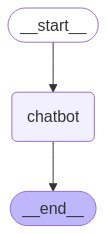

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
from langchain_core.messages import HumanMessage

user_input = "LangGraph가 무엇인가요?"
state : State = {"messages": [HumanMessage(content=user_input)]}
response = graph.invoke(state)

print(response["messages"][-1].content)

LangGraph는 언어와 그래프를 결합한 방법론이나 시스템을 표현할 수 있는 용어로, 자연어 처리(NLP)와 그래프 데이터 구조를 활용하여 정보의 표현 및 분석을 진행하는 데 사용됩니다. 이러한 시스템은 일반적으로 언어의 의미와 구조를 그래프 형태로 모델링함으로써, 복잡한 관계와 패턴을 식별하고 해석하는 데 유용합니다.

예를 들어, 단어와 문장을 노드로, 그들 간의 관계를 엣지로 나타내는 그래프를 구축함으로써, 문맥 이해, 의미 추론, 정보 검색 등의 작업을 더 효과적으로 수행할 수 있습니다. LangGraph와 유사한 시스템이나 기법은 종종 추천 시스템, 지식 그래프, 챗봇 개발 등 다양한 분야에서 응용될 수 있습니다.

보다 구체적인 정보나 예시가 필요한 경우, LangGraph와 관련된 특정 연구나 프로젝트에 대해 알려주시면 더 상세히 설명드릴 수 있습니다.
